In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys, os
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from galaxybrain import ramsey 

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
matplotlib.rc('figure', max_open_warning = 0)

# This notebook is for investigating the results of analysis 
like correlation of subset size and average spectral exponent

In [2]:
                                ####################################################
                                # (NOT NEEDED as of now) Run this to load raw data #
                                ####################################################
from galaxybrain.data_utils import load_mouse_data, return_pops
datafolder = '../../Neuropixel/'

all_mice = []
for i_m in range(3):
    print('Mouse ' + (str(i_m+1)))
    all_mice.append([])
    df_spk, df_info = load_mouse_data(datafolder, i_m, return_type='binned', bin_width=1)
    region_indices = {}
    for region in df_info.region.unique():
        region_indices.update({region:np.where(df_info['region'] == str(region))[0]})
        
    spk_list, region_labels = return_pops(df_spk, df_info)
    print(list(zip(region_labels, [s.shape[1] for s in spk_list])), 'Total:',sum([s.shape[1] for s in spk_list]))
    
    su_start_ind = len(region_labels)+1
    
    all_mice[i_m].append(df_spk[df_spk.columns[su_start_ind:]])
    all_mice[i_m].append(region_indices)
    
krebs = all_mice[0]; robbins = all_mice[1]; waksman = all_mice[2]

raster_dict = {'krebs': [krebs, [('all', 1462), ('CP', 176), ('HPF', 265), ('LS', 122), ('MB', 127), ('TH', 227), ('V1', 334)]],
               'robbins': [robbins, [('all', 2688), ('FrMoCtx', 647), ('HPF', 333), ('LS', 133), ('RSP', 112), ('SomMoCtx', 220), ('TH', 638), ('V1', 251), ('V2', 124)]],
               'waksman': [waksman, [('all', 2296), ('CP', 134), ('HPF', 155), ('TH', 1878)]] }
burn_in = 20 #use for later things 

Mouse 1
Grabbing Spikes...
Binning Spikes...
[('CP', 176), ('FrMoCtx', 78), ('HPF', 265), ('LS', 122), ('MB', 127), ('SC', 42), ('SomMoCtx', 91), ('TH', 227), ('V1', 334)] Total: 1462
Mouse 2
Grabbing Spikes...
Binning Spikes...
[('FrCtx', 31), ('FrMoCtx', 647), ('HPF', 333), ('LS', 133), ('MB', 40), ('RSP', 112), ('SC', 98), ('SSCtx', 50), ('SomMoCtx', 220), ('TH', 638), ('UNK', 11), ('V1', 251), ('V2', 124)] Total: 2688
Mouse 3
Grabbing Spikes...
Binning Spikes...
[('CP', 134), ('FrMoCtx', 86), ('HPF', 155), ('LH', 4), ('LS', 4), ('RSP', 10), ('SomMoCtx', 10), ('TH', 1878), ('UNK', 15)] Total: 2296


In [38]:
data = raster_dict['krebs'][0][0]
#data = np.array(data)
s_ind = np.arange(data.shape[0]) 
np.random.shuffle(s_ind)
raster_curr = data.iloc[s_ind]
raster_curr.shape

(1301, 1462)

In [16]:
x = pd.DataFrame(np.array([[1,2,3,4],
              [5,6,7,8],
              [9,10,11,12]
             ]))
x_s_ind = np.arange(x.shape[1]) 
np.random.shuffle(x_s_ind)
x_curr = x.iloc[:,x_s_ind]
x_curr

,2,0,1,3
0,3,1,2,4
1,7,5,6,8
2,11,9,10,12


In [3]:
x.shape[0]

3

In [2]:
                                ############################
                                # Run this to load results # 
                                ############################
def load_results(in_dir, mice_in,  n_trials, n_iters = 95; n_pc = 0.8; f_range = [0,0.4]; pc_range = [0,1.0]):
    '''n_trials: either number of trials for unshuffled, or number of shuffles'''
    mice_regions = {'krebs': [('all', 1462), ('CP', 176), ('HPF', 265), ('LS', 122), ('MB', 127), ('TH', 227), ('V1', 334)],
                   'robbins': [('all', 2688), ('FrMoCtx', 647), ('HPF', 333), ('LS', 133), ('RSP', 112), ('SomMoCtx', 220), ('TH', 638), ('V1', 251), ('V2', 124)],
                   'waksman': [('all', 2296), ('CP', 134), ('HPF', 155), ('TH', 1878)] }

    #Now loading in ramsey pipeline results
    data_dict = dict() #creating dictionary to hold results

    for mouse_key in mice_in:
        print('=============== \n', 'MOUSE:', mouse_key, '\n=============== ')
        data_dict[mouse_key] = []
        for region in mice_regions[mouse_key]:

            region_name = region[0]; region_count = region[1]
            print(mouse_key, region_name, '(size: ', str(region_count) +')')
            subset_sizes = np.linspace(30,region_count,16, dtype=int)

            decomp_arr = []
            for i in range(n_trials):
                with np.load(in_dir + mouse_key + '/' + region_name + '/ramsey_'+str(i+1)+'.npz', allow_pickle=True) as data:
                    eigs = data['eigs']
                    pows = data['pows']
                    space_r2 = data['space_r2']
                    time_r2 = data['time_r2']
                    pca_m = data['pca_m']
                    ft_m = data['ft_m']
                    psn_r = data['pearson_r']
                    spn_r = data['spearman_rho']
                    psn_p = data['pearson_p']
                    spn_p = data['spearman_p']

                decomp_arr.append([pca_m, ft_m, psn_r, spn_r, psn_p, spn_p])

            decomp_arr = np.array(decomp_arr)
            data = {'subsetsizes':subset_sizes, 'space_r2':space_r2, 'time_r2':time_r2, 'n_iters':n_iters, 'n_pc':n_pc, 'f_range':f_range, 'pc_range':pc_range, 'eigs':eigs, 'pows':pows, 'espec_exp': decomp_arr[:,0].mean(0), 'psd_exp': decomp_arr[:,1].mean(0), 'pearson_corr':decomp_arr[:,2], 'spearman_corr':decomp_arr[:,3], 'pearson_p':decomp_arr[:,4], 'spearman_p':decomp_arr[:,5]}
            data_dict[mouse_key].append((region_name, region_count, data)) #appending a big tuple that includes the data
            
            return data_dict

data_dict = load_results(in_dir ='../data/experiments/exp5/',
                         mice_in = ['krebs'],
                         n_trials = 5,
                         n_iters = 95; n_pc = 0.8; f_range = [0,0.4]; pc_range = [0,1.0])

 MOUSE: krebs 
krebs all (size:  1462)


/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


krebs CP (size:  176)
krebs HPF (size:  265)
krebs LS (size:  122)
krebs MB (size:  127)
krebs TH (size:  227)
krebs V1 (size:  334)
 MOUSE: robbins 
robbins all (size:  2688)
robbins FrMoCtx (size:  647)
robbins HPF (size:  333)
robbins LS (size:  133)
robbins RSP (size:  112)
robbins SomMoCtx (size:  220)
robbins TH (size:  638)
robbins V1 (size:  251)
robbins V2 (size:  124)
 MOUSE: waksman 
waksman all (size:  2296)
waksman CP (size:  134)
waksman HPF (size:  155)
waksman TH (size:  1878)


In [92]:
#np.array([decomp_arr[i][4] for i in range(4)], dtype=float)
np.array([pearson_r[i] for i in range(4)], dtype=float)

array([[ 0.23237682,  0.21879899,  0.08713606,  0.18678611,  0.30246361,
         0.15464726,  0.28440649,  0.17529395,  0.00908455,  0.0193869 ,
         0.02852744,  0.1825308 ,  0.30326148,  0.12628779, -0.06080627,
                nan],
       [ 0.12460806,  0.23283875,  0.31714726,  0.31461366,  0.16819709,
         0.14347704,  0.25068589,  0.18255879,  0.16794513,  0.29400896,
         0.27297032,  0.12393617,  0.03510638, -0.1225084 ,  0.19892217,
                nan],
       [ 0.24349104,  0.19839026,  0.14736842,  0.11620941,  0.26910694,
         0.17635778,  0.09767637,  0.27411814,  0.05596305,  0.31871501,
         0.13366461,  0.11891097,  0.18394457, -0.02919933, -0.09847424,
                nan],
       [ 0.07066069,  0.27413214,  0.2925252 ,  0.28159295,  0.2049972 ,
         0.05942049,  0.14098544,  0.23954367,  0.21522956,  0.24101344,
         0.22434211,  0.18202688,  0.17368421,  0.06804311,  0.15708287,
                nan]])

## Correlating subset size and spectral exponent

Calculate r (pearson, spearman) for each (mouse, region) and average (since for each datum shape is 2d, (95,16)) <br>
Keep in mind each set of exponents is averaged across 4 trials (due to `decomp_arr[:,0 or 1].mean(0)`)

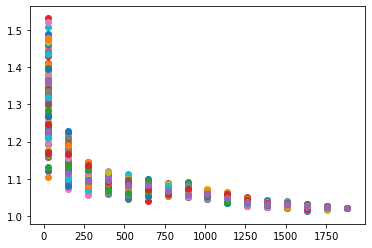

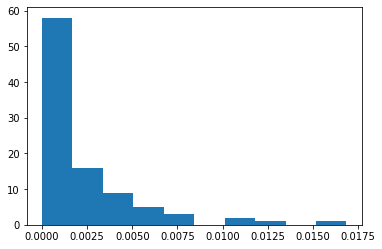

In [34]:
ca = []
for a in e_exp:
    plt.scatter(subsetsizes, a)
    ca.append(stats.pearsonr(subsetsizes, a)[1])
plt.show()
plt.hist(ca, bins=10)
plt.show()

In [3]:
mouse_means_eigx = {'pearson': ([],[]), 'spearman': ([],[])} # see below
mouse_means_psdx = {'pearson': ([],[]), 'spearman': ([],[])} # stat means ([r], [p]) for each region in each mouse, to be averaged again later 
for mouse_key in ['krebs', 'robbins', 'waksman']:
    for region in data_dict[mouse_key]:
        region_name, region_count, data = region[0], region[1], region[2]
        e_exp, p_exp = data['espec_exp'], data['psd_exp']
        subsetsizes = data['subsetsizes']
        espec_corr_array_curr = {'pearson': ([],[]), 'spearman': ([],[])}
        psd_corr_array_curr = {'pearson': ([],[]), 'spearman': ([],[])} # each correlation's array will have a correlation array and a p-value array
        for i in e_exp:
            espec_corr_array_curr['pearson'][0].append(stats.pearsonr(subsetsizes, i)[0])
            espec_corr_array_curr['pearson'][1].append(stats.pearsonr(subsetsizes, i)[1])
            
            espec_corr_array_curr['spearman'][0].append(stats.spearmanr(subsetsizes, i)[0])
            espec_corr_array_curr['spearman'][1].append(stats.spearmanr(subsetsizes, i)[1])
            
        for i in p_exp:
            psd_corr_array_curr['pearson'][0].append(stats.pearsonr(subsetsizes, i)[0])
            psd_corr_array_curr['pearson'][1].append(stats.pearsonr(subsetsizes, i)[1])
            
            psd_corr_array_curr['spearman'][0].append(stats.spearmanr(subsetsizes, i)[0])
            psd_corr_array_curr['spearman'][1].append(stats.spearmanr(subsetsizes, i)[1])
        
        region[2]['subset-exp correlation'] = {'espec': espec_corr_array_curr, 'psd': psd_corr_array_curr}
        
        #appending data for print statment below. Wow this is messy
        mouse_means_eigx['pearson'][0].append(np.mean(espec_corr_array_curr['pearson'][0])); mouse_means_eigx['spearman'][0].append(np.mean(espec_corr_array_curr['spearman'][0]));
        mouse_means_eigx['pearson'][1].append(np.mean(espec_corr_array_curr['pearson'][1])); mouse_means_eigx['spearman'][1].append(np.mean(espec_corr_array_curr['spearman'][1])) 
        
        mouse_means_psdx['pearson'][0].append(np.mean(psd_corr_array_curr['pearson'][0])); mouse_means_psdx['spearman'][0].append(np.mean(psd_corr_array_curr['spearman'][0])) 
        mouse_means_psdx['pearson'][1].append(np.mean(psd_corr_array_curr['pearson'][1])); mouse_means_psdx['spearman'][1].append(np.mean(psd_corr_array_curr['spearman'][1])) 

e_p_m, e_p_p = np.mean(mouse_means_eigx['pearson'][0]), np.mean(mouse_means_eigx['pearson'][1]); e_s_m, e_s_p = np.mean(mouse_means_eigx['spearman'][0]), np.mean(mouse_means_eigx['spearman'][1])
p_p_m, p_p_p = np.mean(mouse_means_psdx['pearson'][0]), np.mean(mouse_means_psdx['pearson'][1]); p_s_m, p_s_p = np.mean(mouse_means_psdx['spearman'][0]), np.mean(mouse_means_psdx['spearman'][1]) 
print('Eigenspectrum: avg subset-exp correlation pearson r:{:.4f}, p:{:.4f}, spearman r:{:.4f}, p:{:.4f}'.format(e_p_m, e_p_p, e_s_m, e_s_p))
print('PSD: avg subset-exp correlation pearson r:{:.4f}, p:{:.4f}, spearman r:{:.4f}, p:{:.4f}'.format(p_p_m, p_p_p, p_s_m, p_s_p))

Eigenspectrum: avg subset-exp correlation pearson r:-0.6349, p:0.0359, spearman r:-0.6553, p:0.0640
PSD: avg subset-exp correlation pearson r:0.4077, p:0.1540, spearman r:0.4169, p:0.1823


<function matplotlib.pyplot.show(*args, **kw)>

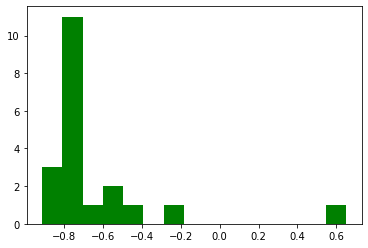

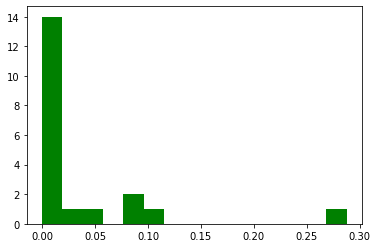

In [6]:
plt.hist(mouse_means_eigx['pearson'][0], bins =15, color='g'); plt.show
plt.figure()
plt.hist(mouse_means_eigx['pearson'][1], bins =15, color='g'); plt.show


# Power law fit

goodness of power law fit increases, variability of goodness of fit decreases <br>
VIZ: same idea: also look at avg r2, std dev

In [36]:
r2_metadata = {'eig':([],[]),'psd':([],[])}
for mouse_key in ['krebs', 'robbins', 'waksman']:
    for region in data_dict[mouse_key]:
        data = region[2]
        subsetsizes = data['subsetsizes']
        e_r2, p_r2 = data['space_r2'], data['time_r2'] #goodness of fits
        r2_metadata['eig'][0].append(e_r2.mean(0))
        r2_metadata['eig'][1].append(e_r2.std(0))
        
        r2_metadata['psd'][0].append(p_r2.mean(0))
        r2_metadata['psd'][1].append(p_r2.std(0))

Text(0.5, 0.04, '% neurons')

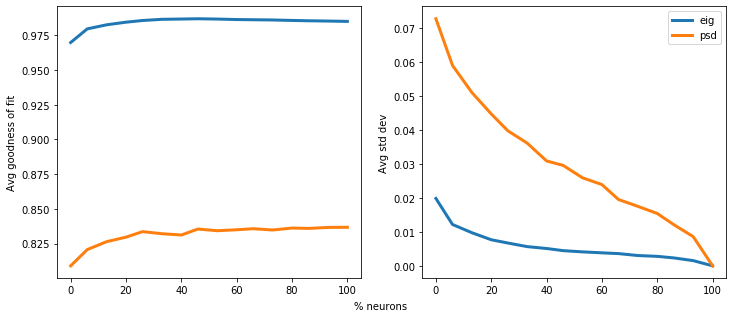

In [52]:
fig = plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(np.linspace(0,100,16, dtype=int), np.array(r2_metadata['eig'][0]).mean(0), linewidth = 3)
plt.plot(np.linspace(0,100,16, dtype=int), np.array(r2_metadata['psd'][0]).mean(0), linewidth = 3)
plt.ylabel('Avg goodness of fit')

plt.subplot(1,2,2)
plt.plot(np.linspace(0,100,16, dtype=int), np.array(r2_metadata['eig'][1]).mean(0), linewidth = 3)
plt.plot(np.linspace(0,100,16, dtype=int), np.array(r2_metadata['psd'][1]).mean(0), linewidth = 3)
plt.ylabel('Avg std dev')
plt.legend(labels = ['eig','psd'])
fig.text(0.5, 0.04, '% neurons', ha='center')

## misc

/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


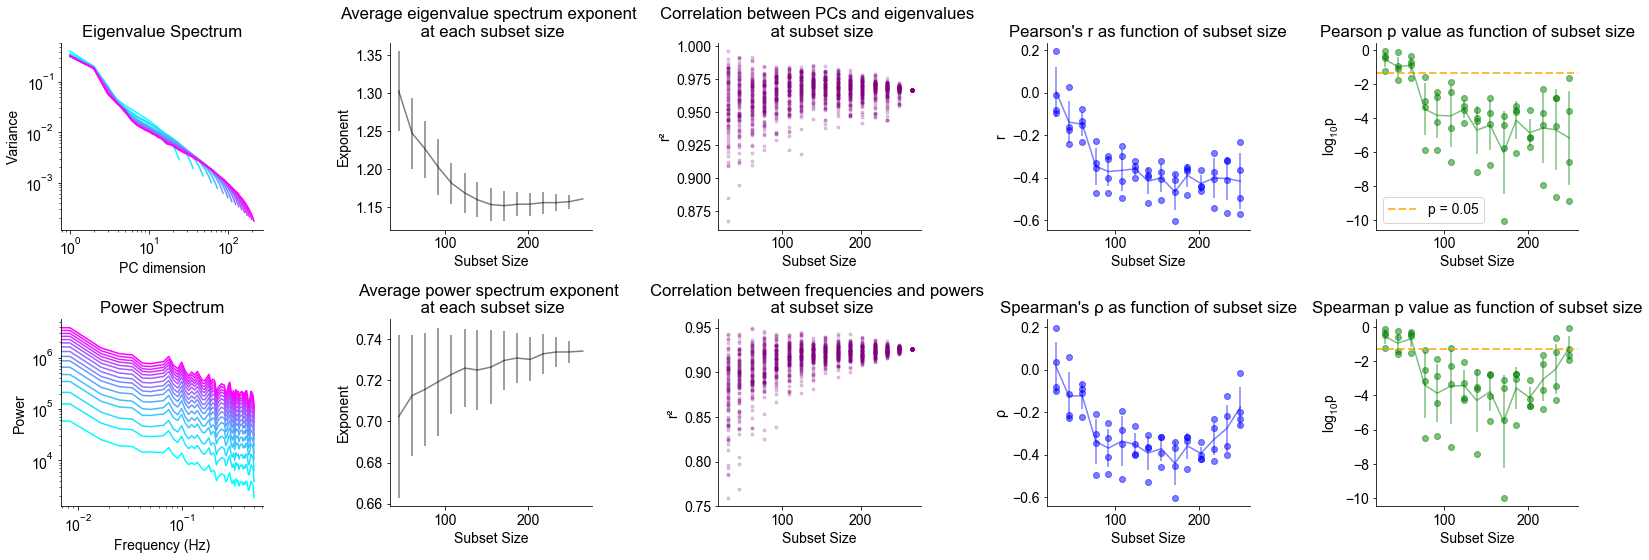

In [23]:
# just trying out plot_all_measures on one (mouse, region)
save = 0
n_iters = 95; n_pc = 0.8; f_range = [0,0.4]; pc_range = [0,None]
decomp_arr = []
subset_sizes = np.linspace(30,265,16, dtype=int)
for i in range(4):
    with np.load('../data/experiments/exp5/krebs/HPF/ramsey_' + str(i+1) + '.npz', allow_pickle=True) as data:
        eigs = data['eigs']
        pows = data['pows']
        space_r2 = data['space_r2']
        time_r2 = data['time_r2']
        pca_m = data['pca_m']
        ft_m = data['ft_m']
        psn_r = data['pearson_r']
        spn_r = data['spearman_rho']
        psn_p = data['pearson_p']
        spn_p = data['spearman_p']
    
    decomp_arr.append([pca_m, ft_m, psn_r, spn_r, psn_p, spn_p])

decomp_arr = np.array(decomp_arr)
ramsey.plot_all_measures(subset_sizes, space_r2, time_r2, n_iters, n_pc, f_range, pc_range, eigs, pows,decomp_arr[:,0].mean(0), decomp_arr[:,1].mean(0), decomp_arr[:,2], decomp_arr[:,3], decomp_arr[:,4], decomp_arr[:,5])
if save:
    plt.savefig('../../fig/conferences/sample_measures')

/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


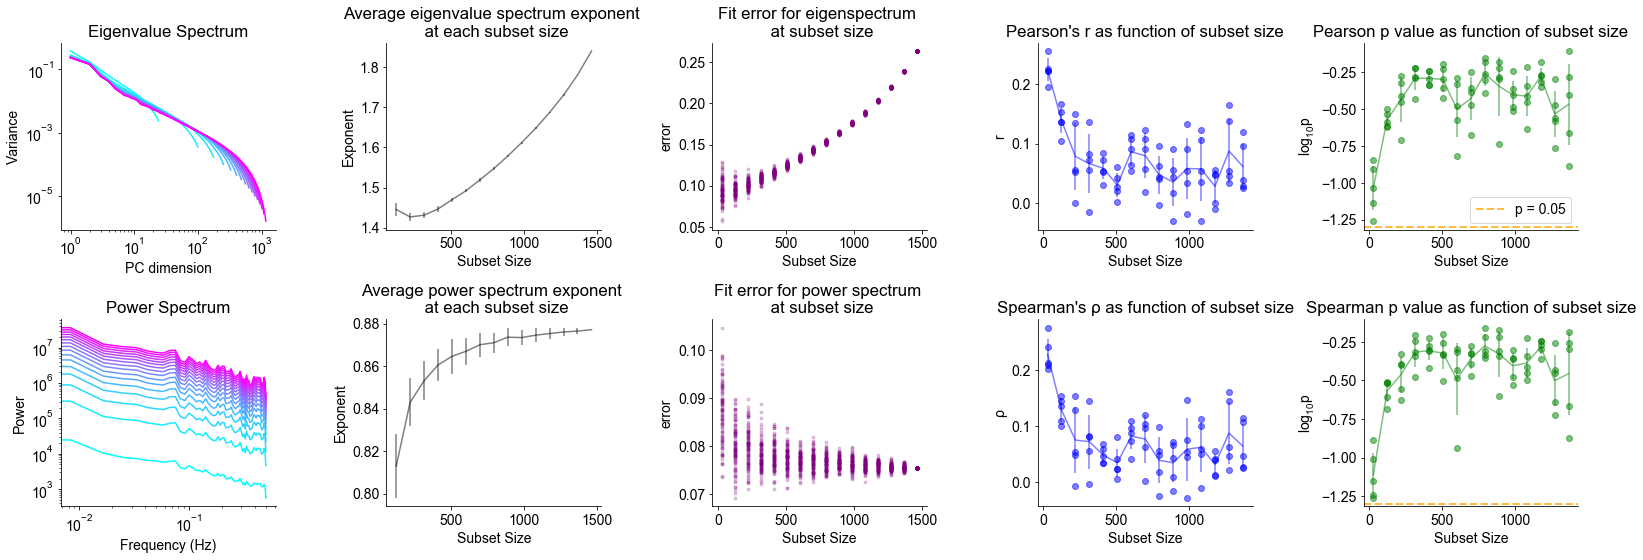

In [17]:
#ramsey_params
n_iters = 95
n_pc = 0.8
pc_range = [0,1.0]
f_range = [0,0.4]
num_trials = 5
shuffle = ('space',5)
decomp_arr = []
subset_sizes = np.linspace(30,1462,16, dtype=int)
for i in range(5):
    with np.load('../data/experiments/expTESTSPACE/krebs/all/ramsey_' + str(i+1) + '.npz', allow_pickle=True) as data:
        eigs = data['eigs']
        pows = data['pows']
        space_er = data['space_er']
        time_er = data['time_er']
        pca_m = data['pca_m']
        ft_m = data['ft_m']
        psn_r = data['pearson_r']
        spn_r = data['spearman_rho']
        psn_p = data['pearson_p']
        spn_p = data['spearman_p']
    
    decomp_arr.append([pca_m, ft_m, psn_r, spn_r, psn_p, spn_p])

decomp_arr = np.array(decomp_arr)
ramsey.plot_all_measures(subset_sizes, space_er, time_er, n_iters, n_pc, f_range, pc_range, eigs, pows,decomp_arr[:,0].mean(0), decomp_arr[:,1].mean(0), decomp_arr[:,2], decomp_arr[:,3], decomp_arr[:,4], decomp_arr[:,5])